In [1]:
from ect import ECT, EmbeddedGraph # for calculating ECTs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
from sklearn.decomposition import PCA # for PCA for normalization
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from sklearn.manifold import MDS # for MDS
import pandas as pd # for loading in colors csv

In [2]:
def normalize(shape):
    """
    input: ordered coordinates of a 2D closed contour
    output: 2D array, coordinates origin centered on centroid and longest radius = 1
    """
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of leaf

    # return leaf normalized by longest axis to 1, zero centered
    return pca_scores/(np.max(pca_scores[:,0])-np.min(pca_scores[:,0]))

In [3]:
def get_ect(normal_sh, dir_num, thresh_num, global_bound_radius):
    """
    inputs: ordered coordinates of a normalized 2D closed contour, longest diameter = 1
    dir_num = number of directional axes
    thresh_num = number of thresholds
    global_bound_radius = half of the longest normalized diameter. If None, then the data is all scaled to radius 1
    output: ECT as 2D array
    """
    G = EmbeddedGraph() # initiate an embedded graph

    valuesX = normal_sh[:,0] # isolate x vals
    valuesY = normal_sh[:,1] # isolate y vals
    for i in range(np.shape(normal_sh)[0]): # create nodes
        G.add_node(i,valuesX[i],valuesY[i])
    for i in range(np.shape(normal_sh)[0]-1): # create edges
        G.add_edge(i, i+1)
    G.add_edge(0,np.shape(normal_sh)[0]-1) # add final edge between start and end

    # Add the rescaling bit: 
    if global_bound_radius == None:
        G.rescale_to_unit_disk(preserve_center=False)
        global_bound_radius = 1

    myect = ECT(num_dirs = dir_num, num_thresh=thresh_num) # intiate ECT
    myect.set_bounding_radius(global_bound_radius) # set bounding radius
    myect.calculateECT(G) # calculate ECT on embedded graph

    return myect.get_ECT() # retrieve ECT, 2D array, [axes, thresh]

In [4]:
def ect_diff(ect1, ect2, dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    diffs = [] # store differences 
    for i in range(dir_num): # for the number of directional axes
        roll_ect = np.roll(ect1,i,axis=0) # roll the array by 1 along directional axes
        diff_ect = np.abs(ect2 - roll_ect) # difference between the two arrays
        diffs.append(np.sum(diff_ect)) # store the sum of the differences
    return np.min(diffs) # return minimum difference

# Get file names of outlines

In [5]:
data_dir = "./outlines/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

print(f"There are {len(file_names)} files in the directory") # print number of files
file_names[:10] # check list of file names

There are 150 files in the directory


['001_figure.txt',
 '002_figure.txt',
 '003_leaf.txt',
 '004_leaf.txt',
 '005_leaf.txt',
 '006_leaf.txt',
 '007_leaf.txt',
 '008_leaf.txt',
 '009_leaf.txt',
 '010_leaf.txt']

# Calculate ECTs for each leaf

In [7]:
%%time

num_dir=50 # set number of directional axes
num_thresh=50 # set number of thresholds each axis

#============
# TESTING RESCALING: 

# rad = 0.5 # set the radius
rad = None # If the radius is set to none, the data is all scaled to radius 1 
#============

# create array to store ECT outputs
# number of ECTs x num directional axes x number of thresholds
ect_arr = np.zeros((len(file_names),num_dir,num_thresh))

for i in range(len(file_names)): # for each leaf
    if i%25==0: # print if divisible by 25
        print(i)
    shape = np.loadtxt("./outlines/"+file_names[i]) # get the current shape
    ect_arr[i,:,:] = get_ect(normal_sh=normalize(shape), # normalize the shape
           dir_num=num_dir, # calculate the ECT
           thresh_num=num_thresh,
           global_bound_radius=rad)

     

0
25
50
75
100
125
CPU times: user 15.4 s, sys: 219 ms, total: 15.7 s
Wall time: 15.9 s


# Create distance matrix of ECTs

In [8]:
%time 
# Dan's version 

# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%25==0: # print if divisible by 25
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff(ect1, ect2, dir_num=num_dir) # get difference between ECTs

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs
0
25
50
75
100
125


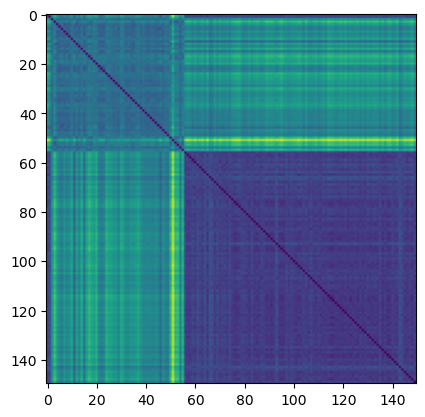

In [10]:
# Visualize distance array
# Remember: 
# figure, leaf, and heart shape files are in order

plt.imshow(dist_arr)

### L2 distance version 



In [11]:
ect_arr.shape


(150, 50, 50)

In [12]:
flattened_ect = ect_arr.reshape(150, 50*50)




In [13]:
from scipy.spatial import distance_matrix


In [14]:
%time
dist_mat_l2 = distance_matrix(flattened_ect, flattened_ect)


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 21.9 µs


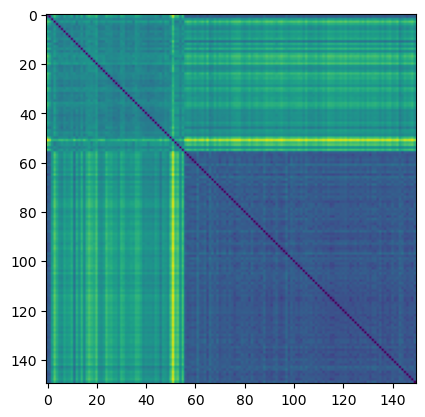

In [15]:
plt.imshow(dist_mat_l2)

dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for 


# Perform MDS

In [16]:
# # Adding some options so you can switch out the distance matrix. Uncomment below to try some other options 


X = dist_arr # Dan's version 
# X = dist_mat_l2 # L2 distance matrix

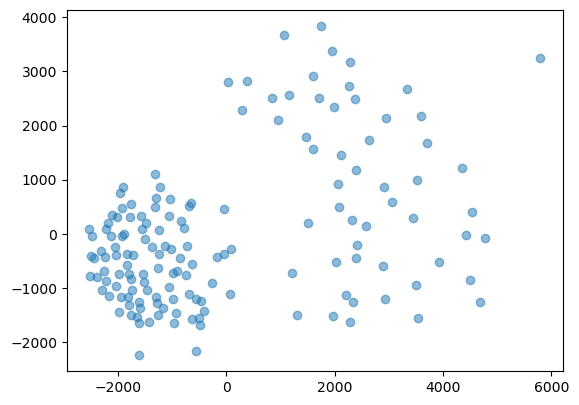

In [17]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")

# Plot

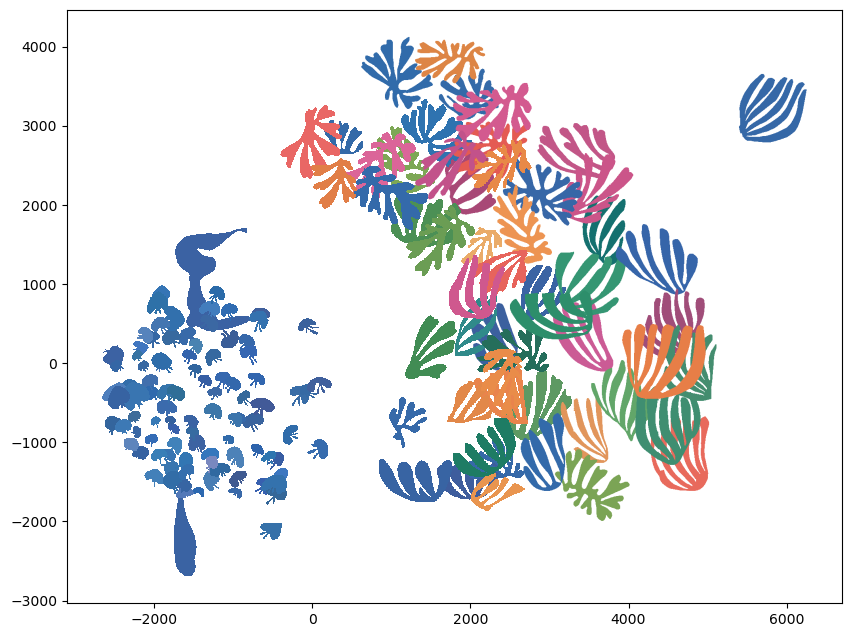

In [18]:
col_df = pd.read_csv("./colors.csv", header=None) # read in color hexcodes
scale_val = 5 # set scale value
plt.figure(figsize=(10,10)) # set figure dimensions

for i in range(len(file_names)): # for each leaf
    
    shape = np.loadtxt("./outlines/"+file_names[i]) # get the current shape

    zero_sh = scale_val*(shape - np.mean(shape, axis=0)) # zero center and scale shape

    trans_sh = (zero_sh + MDS_scores[i]) # translate shape to MDS position

    plt.fill(trans_sh[:,0], trans_sh[:,1], c=col_df[0][i], lw=0) # plot shape
    plt.gca().set_aspect("equal")
    
    

## Drawing the L2 Version

In [19]:
X = dist_mat_l2 # L2 distance matrix



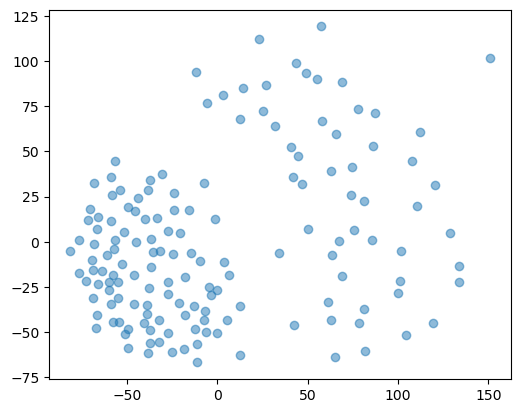

In [20]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")

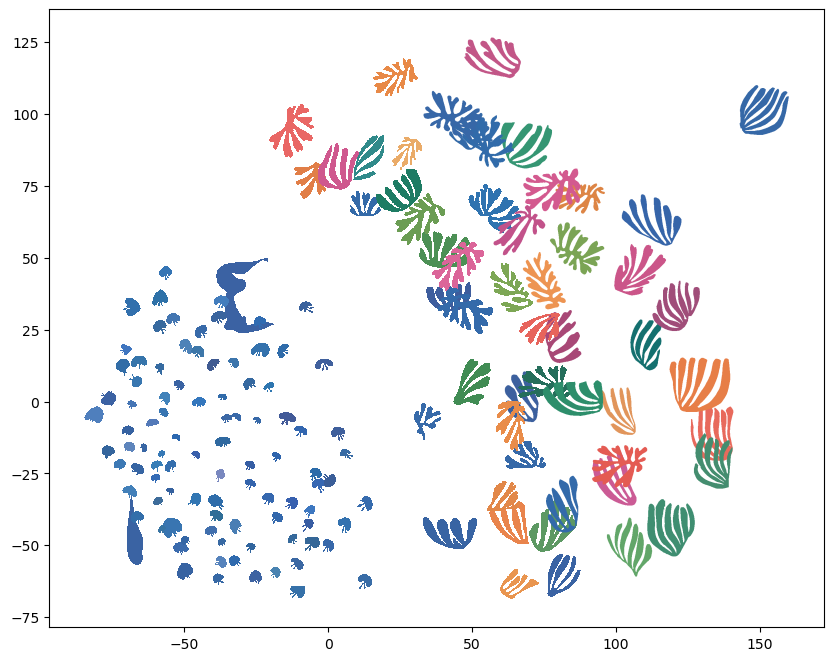

In [21]:
col_df = pd.read_csv("./colors.csv", header=None) # read in color hexcodes
scale_val = .1 # set scale value
plt.figure(figsize=(10,10)) # set figure dimensions

for i in range(len(file_names)): # for each leaf
    
    shape = np.loadtxt("./outlines/"+file_names[i]) # get the current shape

    zero_sh = scale_val*(shape - np.mean(shape, axis=0)) # zero center and scale shape

    trans_sh = (zero_sh + MDS_scores[i]) # translate shape to MDS position

    plt.fill(trans_sh[:,0], trans_sh[:,1], c=col_df[0][i], lw=0) # plot shape
    plt.gca().set_aspect("equal")
    
    plt.savefig('L2_projection.png', bbox_inches = 'tight')